# Классификация отзывов

Интернет-магазин запускает новый сервис, в котором пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Требуется обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.
 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. 

Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

**План**

1. [Первичное ознакомление, анализ данных и подготовка к обучению](#part_1):

      1.1. [Анализ частоты слов](#part_2)
      
      1.2. [Тематика отзывов](#part_3)
      
      1.3. [Учет дисбаланса данных](#part_4)
      
      
2. [Анализ моделей](#part_5)
3. [Определение порога классикации модели](#part_6)
4. [Тестирование](#part_7)
5. [Вывод](#part_8)


<a id='part_1'></a>
## Первичное ознакомление, анализ данных и подготовка к обучению

In [1]:
pip install wordcloud 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import os.path
import nltk
import re
import warnings
import matplotlib.pyplot as plt
import random


from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,  TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import classification_report
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from sklearn.pipeline import Pipeline




from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier


warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

C:\Users\tra88\AppData\Local\Temp\ipykernel_6424\790223502.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tra88\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tra88\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\tra88\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tra88\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\tra88\AppData\Roaming\nltk_data...
[nltk_d

True

In [3]:
data = os.path.abspath('C:/Users/tra88/Downloads/toxic_comments.csv')
toxic_comments = pd.read_csv(data)

In [4]:
# data = os.path.abspath('/datasets/toxic_comments.csv')
# toxic_comments = pd.read_csv(data, index_col=0)

In [5]:
toxic_comments.sample(10)

,Unnamed: 0,text,toxic
157322,157481,"""\n\n Painting of the ArbcomPutting Names to F...",0
16719,16736,"You, too can join the ranks of looking-to-be-o...",1
66050,66117,"""\n\n What happened to your barnstars? \n\n T...",0
101672,101769,Bohemond VI]]'s territories were not minuscule...,0
154686,154843,"I know, the truth hurts. -",0
10007,10020,"May 2008 (UTC)\n\nWolfkeeper, the paragraph co...",0
33318,33358,"TFOWR: Yes, the IDF does allege that they took...",0
83349,83428,. i.e. I won't give up,0
26838,26875,Just ask user:Mkativerata to do that. I am sur...,0
40232,40282,Merge Pillow pants \n\nMerge pillow pants into...,0


In [6]:
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


В датафрейме содержится 159 292 строк и 2 столбца. Посмотрим соотношение отрицательных и положительных отзывов.

0    143106
1     16186
Name: toxic, dtype: int64


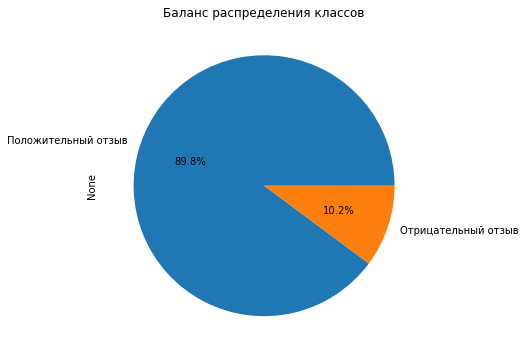

In [7]:
plt.rcParams["figure.figsize"] = [8,6]
print(toxic_comments['toxic'].value_counts())


toxic_comments.groupby('toxic').size().plot(kind='pie',
                                            y = "toxic",
                                            labels=['Положительный отзыв', 'Отрицательный отзыв'],
                                            autopct='%1.1f%%')
plt.title('Баланс распределения классов')
plt.show()

Наблюдается дисбаланс данных в столбце toxic, который необходимо в дальнейшем исследовании.

Необходимо подготовить текст для дальнейшей работы. Создадим собственную функцию, которая лематтизирует данные и очистит от лишних символов в текстах. 

In [8]:
wnl = WordNetLemmatizer()

In [9]:
stopwords = set(nltk_stopwords.words('english'))

In [10]:
def clean_text(text):
    re_text = re.sub(r"[^'a-zA-Z ]", ' ', text) 
    return ' '.join(re_text.split())

In [11]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


In [12]:
def clean_lemm(text):
    tokenizer = []
    for i in nltk.word_tokenize(text):
        y = wnl.lemmatize(i, get_wordnet_pos(i))
        tokenizer.append(clean_text(y))
    return ' '.join([word for word in tokenizer if word not in stopwords])

In [13]:
toxic_comments['lemm_text'] = toxic_comments['text'].progress_apply(clean_lemm).str.lower()

  0%|          | 0/159292 [00:00<?, ?it/s]

Проверим результат работы собственной функции.

In [14]:
toxic_comments.sample(10)

,Unnamed: 0,text,toxic,lemm_text
154749,154906,MVN \nThe page looks excellent. It is quite im...,0,mvn the page look excellent it quite impressi...
140233,140385,"No. It never had the apostrophe, as this was t...",0,no it never apostrophe original french name ...
40411,40461,"""{| style=""""background-color:#F5FFFA; padding:...",0,style '' '' background color f fffa padd...
68292,68360,"""\n\n Proofread of Frank Trigg \n\nHi Ausmus,\...",0,proofread frank trigg hi ausmus great work t...
13475,13490,Right. So where's the block for the people wh...,0,right so 's block people falsely accuse vanda...
65056,65123,REDIRECT User talk:Count de Chagny/Navigation,0,redirect user talk count de chagny navigation
83557,83636,I call bullshit on that! Either behave or I wi...,1,i call bullshit either behave i formally ask ...
98202,98297,"I've reverted this once already, but it must'v...",0,i 've revert already must 've gotten back i n...
31030,31070,Adminship? \n\nI don't know if you've been ask...,0,adminship i n't know 've ask previously woul...
76903,76979,boobies \n\ntatas\n\ntaters\n\nhooters\n\nfunb...,1,booby tatas tater hooter funbags tit hootersho...


<a id='part_2'></a>
### Анализ частоты слов 

Построим облака наиболее частоупотребляемых слов в позитивных и негативных отзывах. 

In [15]:
positive_comments = toxic_comments[toxic_comments["toxic"] == 0]
negative_comments = toxic_comments[toxic_comments["toxic"] == 1]

In [16]:
text_positive = ' '.join(positive_comments['lemm_text'])
text_negative = ' '.join(negative_comments['lemm_text'])

In [17]:
cloud_positive = WordCloud(random_state=1, 
                           background_color='salmon', 
                           colormap='Pastel1', 
                           collocations=False).generate(text_positive)

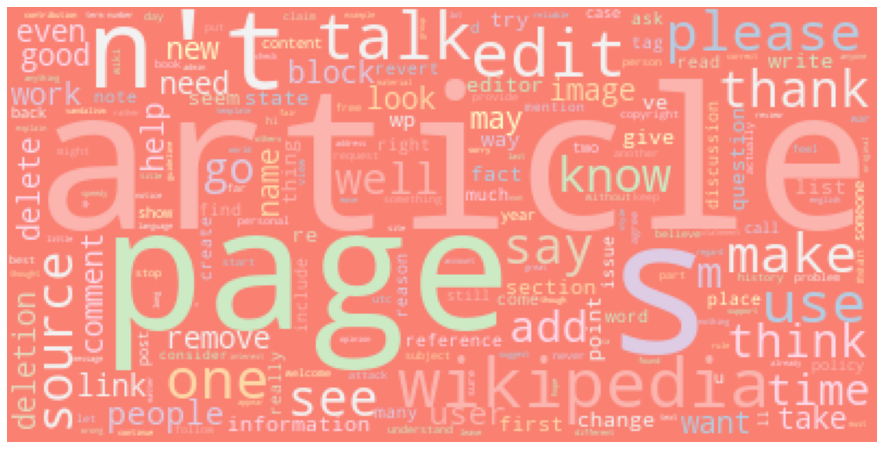

In [18]:
plt.figure(figsize=[18, 8])
plt.imshow(cloud_positive)
plt.axis('off')
plt.show()

In [19]:
cloud_negative = WordCloud().generate(text_negative)

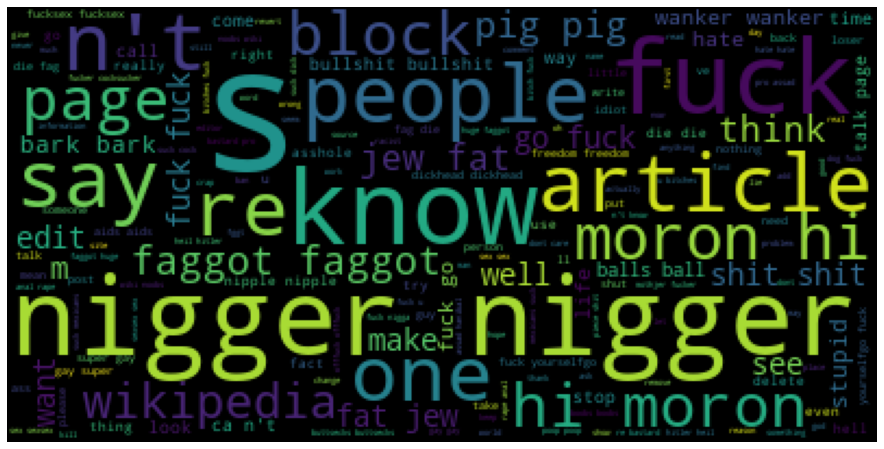

In [20]:
plt.figure(figsize=[18, 8])
plt.imshow(cloud_negative)
plt.axis('off')
plt.show()

Слова в позитивных и негативных отзывах в основном разные, но есть слова, которые встречаются и там, и там. Например слова artice, wikipedia, page, one, edit и другие. 

В целом в позитивных отзывах присутствуют слова с позитивным смыслом или нейтральные, такие как thank, see и т.д. В негативных отзывах присутствуют слова, несущие негативный посыл (например, fuck и nigger), и также есть слова с нейтральным смыслом.

<a id='part_3'></a>
### Тематики отзывов

Распределим слова из отзывов на тематики, чтобы сложить представление о чем идет речь в отзывах.

In [21]:
count_vect = CountVectorizer(max_df=0.8, min_df=2)
doc_term_matrix = count_vect.fit_transform(toxic_comments['lemm_text'].values.astype('U'))

In [22]:
LDA = LatentDirichletAllocation(n_components=4, random_state=42)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=4, random_state=42)

Выведем для ознакомления 10 наиболее вероятных слов для каждой темы.

In [23]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')


Top 10 words for topic #0:
['you', 'http', 'please', 'list', 'wikipedia', 'copyright', 'if', 'page', 'use', 'image']


Top 10 words for topic #1:
['know', 'block', 'talk', 'say', 'edit', 'like', 'get', 'page', 'make', 'you']


Top 10 words for topic #2:
['would', 'if', 'source', 'the', 'add', 'please', 'talk', 'wikipedia', 'page', 'article']


Top 10 words for topic #3:
['people', 'would', 'also', 'in', 'it', 'say', 'one', 'you', 'fuck', 'the']




Исходя из полученного списка можно предположить, что в тематике под номером #3 преобладают негативные отзывы, т.к. с списке слов преобладают оскорбительные слова.

In [24]:
topic_values = LDA.transform(doc_term_matrix)
topic_values.shape

(159292, 4)

Добавим полученные тематики в таблицу и выведем 20 случайных сторк, чтобы проверить, что получилось в итоге.

In [25]:
toxic_comments['topic'] = topic_values.argmax(axis=1)

In [26]:
toxic_comments.sample(20)

,Unnamed: 0,text,toxic,lemm_text,topic
40477,40527,""" But origin of this word came from the Tatar ...",0,but origin word come tatar language mean ''...,3
49102,49157,[[User talk:[JohnCD]JohnCD|talk]] - are you go...,0,user talk johncd johncd talk go reply ...,2
73516,73588,stop pretending \n\nStop pretending to be cool...,1,stop pretend stop pretend cool i n't really c...,1
31136,31176,"""\n\n""""Incremental change"""" is the key, as I a...",0,'' '' incremental change '' '' key i already...,2
29247,29284,Thank you! And now I say:,0,thank and i say,1
107336,107433,WikiProject History of Science newsletter Iss...,0,wikiproject history science newsletter issue i...,2
110650,110747,"Hello, welcome to Wikipedia. Please do not cop...",0,hello welcome wikipedia please copy paste te...,2
63322,63389,"""\n\nBoth names are correct. So there is no ne...",0,both name correct so need change one articl...,2
135423,135561,"(Betterly phrased, hey I created a new word, b...",0,betterly phrase hey i create new word bette...,2
77740,77816,-\n\nThe network has also produced and acquire...,0,the network also produce acquire new original...,0


Необходимо разделить датафрейм на обучающую и тестовые выборки в соотношении 3:1, а также выделить признаки и целевой.

Создадим собственную функцию для разделения данных на выборки в соотношении 3:1 и выделения признаков и целевого признака.

In [27]:
random = 42

In [28]:
def features_target(data, random, column):
    features = data.drop([column], axis=1)
    target = data[column]
    features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                                test_size=.25, 
                                                                                random_state=random,
                                                                                stratify=target)
    
    print("Размер обучающей выборки: {:.0%}".format(features_train.shape[0]/ data.shape[0]))
    print("Размер тестовой выборки: {:.0%}".format(features_test.shape[0]/ data.shape[0]))
    return features_train, features_test, target_train, target_test
    

In [29]:
features_train, features_test, target_train, target_test = features_target(toxic_comments, random, 'toxic')

Размер обучающей выборки: 75%
Размер тестовой выборки: 25%


**Вывод:**
Были загружены данные и сделаны следующие действия:
* Данные очищены от лишних знаков, лемматизированы и очищены от слов без смысловой нагрузки.
* Разделение данных на 2 выборки: обучающую и тестовую в соотношении 3:1. Так же были выделены признаки и целевой признак.
* Был выявлен дисбаланс в данных. Для борьбы с дисбалансом в дальнейшем оптимально использовать метод учета веса классов.
* Так же проведен анализ слов в негативных и положительных отзывах. Есть слова которые присутствуют и в положительных и в отрицательных. Наиболее часто употребляемые слова все же имеют различия в зависимости от эмоциональной окраски отзыва. 
* Всем отзывам присвоили тематику на основе проведенной обработки. 


<a id='part_4'></a>
### Учет дисбаланса данных

Займемся учетом дисбаланса в данных. Для сравнения посмотрим на результаты метрики модель LogisticRegression без учета дисбаланса и с учетом дисбаланса.

**LogisticRegression**

In [30]:
cv = 5

In [31]:
pipeline_lg = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf',LogisticRegression(random_state=random))])


In [32]:
cv_f1_lm = cross_val_score(pipeline_lg, 
                           features_train['lemm_text'], 
                           target_train, 
                           cv=cv, 
                           scoring='f1').mean()
print('F1 для LogisticRegression =', cv_f1_lm)

F1 для LogisticRegression = 0.7292265712551023


При игнорировании дисбаланса, показатели метрики f1 ниже установленного порога значения.

**LogisticRegression + Balance**

In [33]:
pipeline_lg_balance = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf',LogisticRegression(random_state=random, class_weight='balanced'))])

In [34]:
%%time

cv_f1_lm_balance = cross_val_score(pipeline_lg_balance, 
                                   features_train['lemm_text'], 
                                   target_train, 
                                   cv=cv, 
                                   scoring='f1').mean()
print('F1 для LogisticRegression + Balance =', cv_f1_lm_balance)

F1 для LogisticRegression + Balance = 0.7447964549897723
CPU times: total: 1min 24s
Wall time: 30.2 s


При использовании баланса показатель метрики повышается примерно на 0,05.

**ROC-кривая**

Для наглядности результатов постором график ROC-кривая и занесем результаты в таблицу.

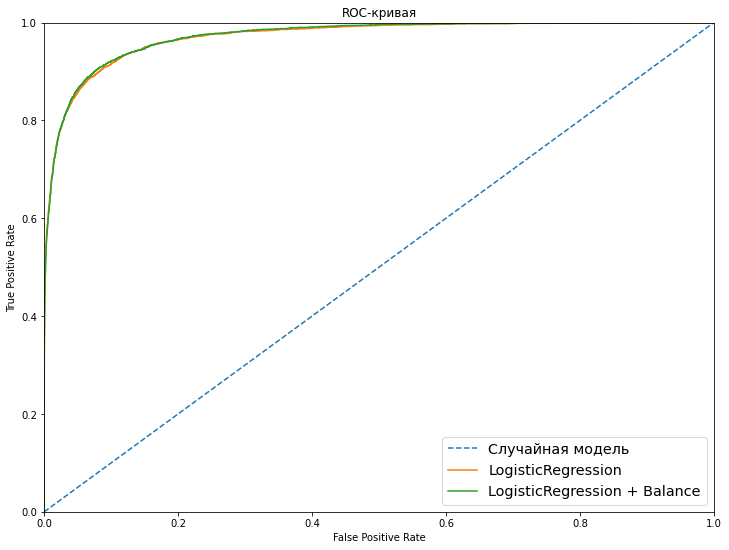

In [35]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')


pipeline_lg.fit(features_train['lemm_text'], target_train)
probabilities_test = pipeline_lg.predict_proba(features_test['lemm_text'])
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
f1_test = f1_score(target_test, pipeline_lg.predict(features_test['lemm_text']))
plt.plot(fpr, tpr, label='LogisticRegression')

# model = LogisticRegression(class_weight='balanced', random_state=random)
pipeline_lg_balance.fit(features_train['lemm_text'], target_train)
probabilities_test = pipeline_lg_balance.predict_proba(features_test['lemm_text'])
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc_balance = roc_auc_score(target_test, probabilities_one_test)
f1_test_balance = f1_score(target_test, pipeline_lg_balance.predict(features_test['lemm_text']))
plt.plot(fpr, tpr, label='LogisticRegression + Balance')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

In [36]:
index = ['LogisticRegression',
         'LogisticRegression + Balance']
data = {'F1 на CV':[cv_f1_lm,
                    cv_f1_lm_balance],
        'F1 на test':[f1_test,
                      f1_test_balance],
        'AUC-ROC':[auc_roc,
                   auc_roc_balance]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data

,F1 на CV,F1 на test,AUC-ROC
LogisticRegression,0.729227,0.733126,0.970779
LogisticRegression + Balance,0.744796,0.750942,0.971824


**Вывод:**

С учетом полученных результатов устранение дисбаланса при помощи взвешивания весов класса оказывает влияние и повышает значение метрики f1.

<a id='part_5'></a>
## Анализ моделей

Для дальнейшего исследования были отобраны следующие модели:
 * LogisticRegression
 * DecisionTreeClassifier
 * SGDClassifier

Прежде чем приступить к подбору оптимальных параметров и обучению моделей, создадим таблицу для занесения в нее результатов.

In [37]:
index_table_result = 0
table_result = pd.DataFrame(columns=['Модель','F1 на CV'])

### LogisticRegression

In [38]:
piplene_ln_balance = Pipeline([('vect', TfidfVectorizer(ngram_range=(1,3))), 
                               ('clf',LogisticRegression())])

In [39]:
params = [{'clf__solver':['newton-cg', 'lbfgs', 'liblinear'],
          'clf__C':[.01,1,10],
          'clf__penalty':['l1','l2'],
          'clf__random_state':[random],
          'clf__class_weight':['balanced']}]

In [40]:
grid = GridSearchCV(piplene_ln_balance, cv=5, n_jobs=-1, param_grid=params ,scoring='f1')
grid.fit(features_train['lemm_text'], target_train)
lg_balance_final = grid.best_estimator_

print(grid.best_params_)
print()
print('F1 для CV LogistigRegression =', grid.best_score_)

{'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__random_state': 42, 'clf__solver': 'newton-cg'}

F1 для CV LogistigRegression = 0.7687544686421914


In [41]:
index_table_result +=1
table_result.loc[index_table_result] = ['LogisticRegression ', grid.best_score_]
table_result

,Модель,F1 на CV
1,LogisticRegression,0.768754


### DecisionTreeClassifier

In [42]:
pipeline_tree = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', DecisionTreeClassifier())])

In [43]:
hyperparams = {'clf__max_depth':[x for x in range(1, 10)],
              'clf__random_state':[random],
              'clf__class_weight':['balanced']}

In [44]:
%%time

grid_tree = GridSearchCV(pipeline_tree, hyperparams, cv=cv, scoring='f1')
grid_tree.fit(features_train['lemm_text'], target_train)

tree_final = grid_tree.best_estimator_

print(grid_tree.best_params_)
print()
print('F1 для DecisionTreeClassifier =', grid_tree.best_score_)

{'clf__class_weight': 'balanced', 'clf__max_depth': 9, 'clf__random_state': 42}

F1 для DecisionTreeClassifier = 0.5289042292604484
CPU times: total: 4min 12s
Wall time: 4min 13s


In [45]:
index_table_result +=1
table_result.loc[index_table_result] = ['DecisionTreeClassifier ', grid_tree.best_score_]
table_result

,Модель,F1 на CV
1,LogisticRegression,0.768754
2,DecisionTreeClassifier,0.528904


### SGDClassifier

In [46]:
pipeline_sgd = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier())])

In [47]:
hyperparams = [{'clf__loss':['hinge', 'log', 'modified_huber'],
                'clf__learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'],
                'clf__eta0':[0.01, 0.05, 0.1, 0.2, 0.3, 0.5], 
                'clf__random_state':[random],
                'clf__class_weight':['balanced']}]

In [48]:
%%time

grid_sgdc = GridSearchCV(pipeline_sgd, hyperparams, scoring='f1',cv=cv)
grid_sgdc.fit(features_train['lemm_text'], target_train)

sgdc_final = grid_sgdc.best_estimator_

print(grid_sgdc.best_params_)
print()
print('F1 для SGDClassifier =', grid_sgdc.best_score_)

{'clf__class_weight': 'balanced', 'clf__eta0': 0.5, 'clf__learning_rate': 'adaptive', 'clf__loss': 'modified_huber', 'clf__random_state': 42}

F1 для SGDClassifier = 0.7503570917791531
CPU times: total: 37min 53s
Wall time: 26min 43s


In [49]:
index_table_result +=1
table_result.loc[index_table_result] = ['SGDClassifier', grid_sgdc.best_score_]
table_result

,Модель,F1 на CV
1,LogisticRegression,0.768754
2,DecisionTreeClassifier,0.528904
3,SGDClassifier,0.750357


По полученным результатам наилучшие показатели метрики f1 получились на модели LogisticRegression. Для наглядности построим график распределения для наших моделей.

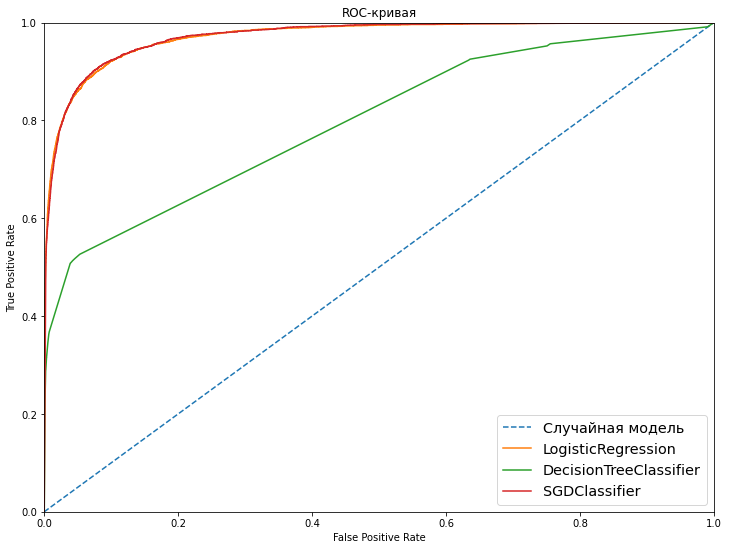

In [50]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')

probabilities_test = lg_balance_final.predict_proba(features_test['lemm_text'])
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc_lg = roc_auc_score(target_test, probabilities_one_test)
plt.plot(fpr, tpr, label='LogisticRegression')

probabilities_test = tree_final.predict_proba(features_test['lemm_text'])
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc_tree = roc_auc_score(target_test, probabilities_one_test)
plt.plot(fpr, tpr, label='DecisionTreeClassifier')

probabilities_test = sgdc_final.predict_proba(features_test['lemm_text'])
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc_sgdc = roc_auc_score(target_test, probabilities_one_test)
plt.plot(fpr, tpr, label='SGDClassifier')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

In [51]:
index = ['LogisticRegression',
         'DecisionTreeClassifier',
         'SGDClassifier']
data = {'F1 на CV':[grid.best_score_,
                    grid_tree.best_score_,
                    grid_sgdc.best_score_],
        'AUC-ROC':[auc_roc_lg,
                   auc_roc_tree,
                   auc_roc_sgdc]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data

,F1 на CV,AUC-ROC
LogisticRegression,0.768754,0.971793
DecisionTreeClassifier,0.528904,0.796716
SGDClassifier,0.750357,0.971877


**Вывод:**

Наилучшие показатели метрики f1 у модели LogisticRegression. На втором месте SGDClassifier. Наихудшие показатели метрики f1 у модели DecisionTreeClassifier. 

Для тестирования будем использовать модель LogisticRegression.

<a id='part_6'></a>
## Определение порога классификации

Прежде чем приступить к итоговому тестированию отобранной модели. Определем порог классификации для LogisticRegression.

In [52]:
probabilities_test = lg_balance_final.predict_proba(features_test['lemm_text'])
probabilities_one_test = probabilities_test[:, 1]

for threshold in np.arange(0.3, 0.9, 0.02):
    predicted_v = probabilities_one_test > threshold
    precision = precision_score(target_test,predicted_v)
    recall = recall_score(target_test,predicted_v) 
    f1 = f1_score(target_test,predicted_v)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}".format(
        threshold, precision, recall, f1))

Порог = 0.30 | Точность = 0.630, Полнота = 0.875, F1 = 0.733
Порог = 0.32 | Точность = 0.640, Полнота = 0.867, F1 = 0.737
Порог = 0.34 | Точность = 0.655, Полнота = 0.863, F1 = 0.745
Порог = 0.36 | Точность = 0.665, Полнота = 0.859, F1 = 0.750
Порог = 0.38 | Точность = 0.677, Полнота = 0.852, F1 = 0.754
Порог = 0.40 | Точность = 0.689, Полнота = 0.848, F1 = 0.760
Порог = 0.42 | Точность = 0.697, Полнота = 0.843, F1 = 0.763
Порог = 0.44 | Точность = 0.707, Полнота = 0.836, F1 = 0.766
Порог = 0.46 | Точность = 0.719, Полнота = 0.833, F1 = 0.772
Порог = 0.48 | Точность = 0.728, Полнота = 0.825, F1 = 0.773
Порог = 0.50 | Точность = 0.735, Полнота = 0.819, F1 = 0.775
Порог = 0.52 | Точность = 0.745, Полнота = 0.815, F1 = 0.778
Порог = 0.54 | Точность = 0.754, Полнота = 0.809, F1 = 0.781
Порог = 0.56 | Точность = 0.762, Полнота = 0.805, F1 = 0.783
Порог = 0.58 | Точность = 0.771, Полнота = 0.798, F1 = 0.784
Порог = 0.60 | Точность = 0.778, Полнота = 0.791, F1 = 0.785
Порог = 0.62 | Точность 

Построим график Точность-Полнота.

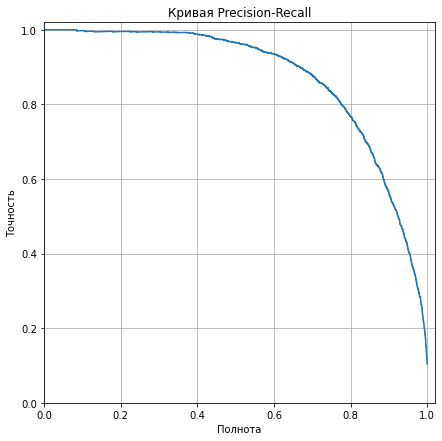

In [53]:
precision, recall, thresholds = precision_recall_curve(target_test, probabilities_test[:, 1])
plt.figure(figsize=(7, 7))
plt.grid(True)
plt.step(recall, precision, where='post')
plt.xlabel('Полнота')
plt.ylabel('Точность')
plt.ylim([0.0, 1.02])
plt.xlim([0.0, 1.02])
plt.title('Кривая Precision-Recall')
plt.show() 

Наиболее подходящим выглядит пороговое значение 0.72. 

In [54]:
predicted_rf_threshold=(probabilities_one_test>0.72)*1
print(classification_report(target_test,predicted_rf_threshold, target_names=['Положительный отзыв','Отрицательный отзыв']))

                     precision    recall  f1-score   support

Положительный отзыв       0.97      0.98      0.98     35777
Отрицательный отзыв       0.83      0.75      0.79      4046

           accuracy                           0.96     39823
          macro avg       0.90      0.87      0.88     39823
       weighted avg       0.96      0.96      0.96     39823



<a id='part_7'></a>
## Тестирование 

Получим предсказания наилучшей модели с учетом наиболее оптимального порога классификации.

In [55]:
final_model_lg = grid.best_estimator_
predict_lg = (final_model_lg.predict_proba(features_test['lemm_text'])[:,1]>0.72)*1
f1_final_lg = f1_score(target_test, predict_lg)
print('F1 на тестовой выборке', f1_final_lg)

F1 на тестовой выборке 0.7892967942088934


Метрика f1 на тестовой выборке с учетом подобранных параметров и учета порога классификации показала значение выше требуемого, значит данную модель мы можем использовать для дальнейшей работы.

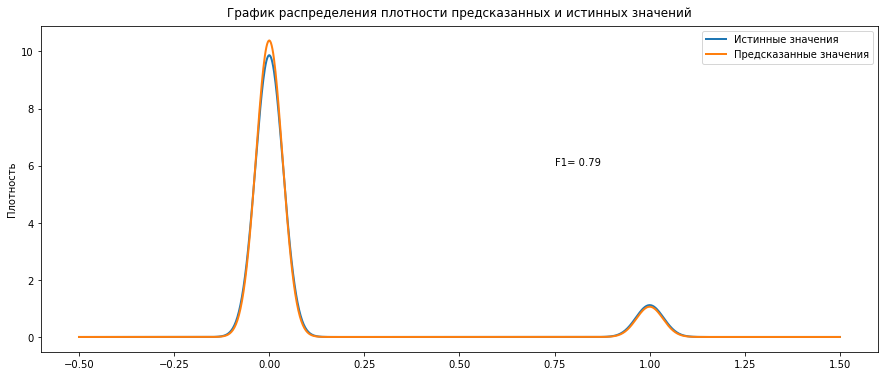

In [56]:
plt.figure(figsize=(15, 6))
target_test.plot(kind='kde', linewidth=2)
pd.Series(predict_lg).plot(kind='kde',linewidth=2)
plt.title('График распределения плотности предсказанных и истинных значений', y=1.01)
plt.legend(['Истинные значения','Предсказанные значения'])
plt.text(0.75,6,'F1= {:.2f}'.format(f1_final_lg))
plt.xlabel('')
plt.ylabel('Плотность')
plt.show()

**Вывод:**

Метрика f1 на тестовой выборке с учетом подобранных параметров и учета порога классификации показала значение выше требуемого, значит данную модель мы можем использовать для дальнейшей работы.

<a id='part_8'></a>
## Вывод

В результате исследования было сделано следующее:
    
* В датафрейме содержится 159 292 строк и 2 столбца. Пропусков в данных не обнаружено. Поскольку у нас стояла задача классификации отзывов и работать предстояло с текстом, то была проведена предобработка текста(очистка от лишних символов и слов без смысловой нагрузки, лемматизированы слова).

* При изучении данных был обнаружен дисбаланс. Для устранения дисбаланса наиболее подходящим методом оказался учет веса класса. Так же был проведен анализ по частоте употребляемых слов в положительных и отрицательных отзывах и дополнительно сделанная классификация отзывов по тематикам.

* Для анализа было отобрано 3 модели:
     * LogisticRegression
     * DecisionTreeClassifier
     * SGDClassifier

* По условию поставленной задачи метрика f1 должна быть не ниже 0,75. Исходя из этого модель DecisionTreeClassifier выдала наихудший показатель при подборе оптимальных параметров:
     * F1 на CV для DecisionTreeClassifier = 0.528904
     
* Наилучший показатель метрики f1 у модели LogisticRegression:
     * F1 на CV для LogisticRegression = 0.768790
     * F1 на тестовой выборки для LogisticRegression = 0.7906916612798965
    
* Исходя из результатов проведенного исследования для решения поставленной задачи наиболее подходящей является модель LogisticRegression c учетом веса класса и установкой порогового значения классификации >0.72.